In [1]:
# 1. data

In [2]:
from sklearn.datasets import make_circles

In [31]:
# makes 1000 circles
n_samples=1000
#create circles
X,y=make_circles(n_samples,
                noise=0.03,
                random_state=42)

In [4]:
len(X),len(y)

(1000, 1000)

In [8]:
print(f" first 5 sample of X : \n {X[:5]}")
print(f" first 5 sample of y : \n {y[:5]}")

 first 5 sample of X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
 first 5 sample of y : 
 [1 1 1 1 0]


In [9]:
#make dataframe of circle data
import pandas as pd
circles=pd.DataFrame({"X1": X[:,0],
                      "X2": X[:,1],
                      "label": y})

In [11]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


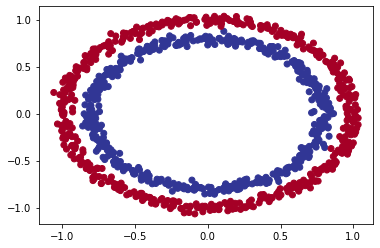

In [15]:
#vis
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu)

In [16]:
## check input and output shapes

In [32]:
X.shape, y.shape,X.dtype

((1000, 2), (1000,), dtype('float64'))

In [21]:
import torch
import torch.nn as nn


In [33]:
#X=torch.Tensor(X)
#y=torch.Tensor(y)
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [36]:
#split 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=42,test_size=0.2)

In [37]:
len(X_train),len(X_test)

(800, 200)

In [ ]:
#building a model


In [40]:
#device agnostic
device="cuda" if torch.cuda.is_available() else "cpu"

In [42]:
class classification(nn.Module):
    def __init__(self):
        super(classification,self).__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=8)
        self.layer_2=nn.Linear(in_features=8,out_features=1)
    
    def forward(self,x):
        
        return self.layer_2(self.layer_1(x))

In [93]:
model_0=classification().to(device)

In [50]:
#use of nn.sequential
torch.manual_seed(42)
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [51]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('0.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('1.bias', tensor([-0.2060]))])

In [55]:
with torch.inference_mode():
    model_0.eval()
    y_pred=model_0(X_test.to(device))

In [57]:
len(y_pred),y_pred.shape

(200, torch.Size([200, 1]))

In [ ]:
#setup loss function and optimizer

In [97]:
loss_func=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_0.parameters(),lr=0.1)

In [68]:
#calculate the accuracy
def accuracy(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    return (correct)/len(y_pred)*100

In [69]:
accuracy(y_test,y_pred)

0.0

## logits

In [79]:
#view first
model_0.eval()
with torch.inference_mode():
    y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])

In [80]:
#use the sigmoid activation function to get predction probability
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]])

In [89]:
#find the label from predicted probalilty 
y_preds=torch.round(y_pred_probs)

#in full
y_pred_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [90]:
#testing

print(y_preds.squeeze(),y_pred_labels.squeeze())

tensor([0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)


In [100]:
#training model
torch.manual_seed(42)
epochs=100
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

train_loss_values=[]
test_loss_values=[]
epoch_count=[]
for epoch in range(epochs):
    model_0.train()
    y_logits=model_0(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))
    
    #calculate the loss/accuaracy
    loss=loss_func(y_logits,y_train)
    acc=accuracy(y_true=y_train,y_pred=y_pred)
    #optim zero grad
    optimizer.zero_grad()
    #back prop
    loss.backward()
    #optimizer.step gradient descent
    optimizer.step()
    
    #testing
    model_0.eval()
    with torch.inference_mode():
        y_test_logits=model_0(X_test).squeeze()
        y_test_pred=torch.round(torch.sigmoid(y_test_logits))
        loss_test=loss_func(y_test_logits,y_test)
        acc_test=accuracy(y_true=y_test,y_pred=y_test_pred)
    #print happening
    if epoch % 10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy : {acc:.5f}% | Test_loss {loss_test:.5f} | Test_accuracy {acc_test:.5f}% ")

Epoch: 0 | Loss: 0.69301 | Accuracy : 51.37500% | Test_loss 0.69396 | Test_accuracy 46.00000% 
Epoch: 10 | Loss: 0.69301 | Accuracy : 51.62500% | Test_loss 0.69405 | Test_accuracy 45.50000% 
Epoch: 20 | Loss: 0.69300 | Accuracy : 51.37500% | Test_loss 0.69413 | Test_accuracy 45.50000% 
Epoch: 30 | Loss: 0.69299 | Accuracy : 51.62500% | Test_loss 0.69420 | Test_accuracy 45.50000% 
Epoch: 40 | Loss: 0.69299 | Accuracy : 51.62500% | Test_loss 0.69426 | Test_accuracy 45.50000% 
Epoch: 50 | Loss: 0.69299 | Accuracy : 51.62500% | Test_loss 0.69432 | Test_accuracy 45.50000% 
Epoch: 60 | Loss: 0.69299 | Accuracy : 51.50000% | Test_loss 0.69436 | Test_accuracy 45.00000% 
Epoch: 70 | Loss: 0.69298 | Accuracy : 51.50000% | Test_loss 0.69440 | Test_accuracy 45.00000% 
Epoch: 80 | Loss: 0.69298 | Accuracy : 51.37500% | Test_loss 0.69444 | Test_accuracy 45.00000% 
Epoch: 90 | Loss: 0.69298 | Accuracy : 51.37500% | Test_loss 0.69447 | Test_accuracy 45.00000% 


In [101]:
## 4. Makin the predcition


In [105]:
import requests
from pathlib import Path
# download helper function
if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skipping download")
else:
    print("Downloading helper function")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

In [106]:
#plot decision boundary
from helper_functions import plot_decision_boundary,plot_predictions

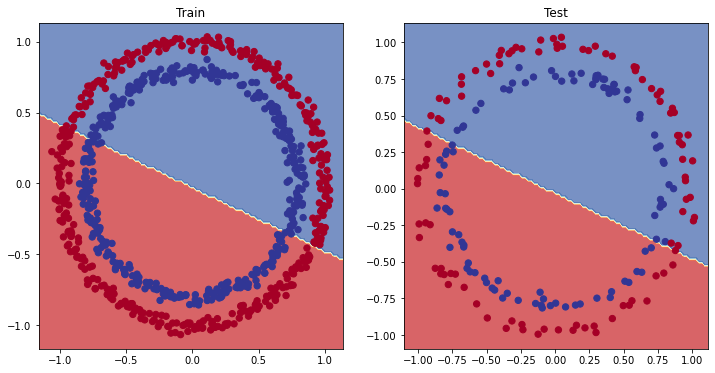

In [109]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

# improving our model
1. add layers
2. add more hidden units
3. fit for lonnger
4. Changing the activation function
5. adjusting learning rate
6. Change the loss function

In [111]:
# creating the improved models


In [113]:
class CircleModel(nn.Module):
    def __init__(self):
        super(CircleModel,self).__init__()
        self.layer1=nn.Linear(in_features=2,out_features=128,bias=True,device=device)
        self.layer2=nn.Linear(in_features=128, out_features=256, bias=True,device=device)
        self.layer3=nn.Linear(in_features=256, out_features=20,bias=True,device=device)
        self.layer4=nn.Linear(in_features=20,out_features=1,device=device,bias=True)
    
    def forward(self,x):
        z=self.layer1(x)
        z=self.layer2(z)
        z=self.layer3(z)
        z=self.layer4(z)
        return z

In [126]:
model_1=CircleModel().to(device)
model_1

CircleModel(
  (layer1): Linear(in_features=2, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=1, bias=True)
)

In [127]:
#create a loss function
loss_func=torch.nn.BCEWithLogitsLoss()
#create a optimizer
optimizer=torch.optim.Adam(model_1.parameters(),lr=0.01)

In [128]:
def acc_func(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    return correct/len(y_pred)*100

In [129]:
#create a training and optimization loop
torch.manual_seed(42)
epochs=100
#put data in target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_train=X_test.to(device),y_test.to(device)

train_loss_values=[]
test_loss_values=[]
epoch_count=[]
train_accuracy=[]
test_accuracy=[]
for epoch in range(epochs):
    model_1.train()
    y_pred_logits=model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_pred_logits))
    
    accuracy=acc_func(y_train,y_pred)
    
    loss=loss_func(y_pred_logits,y_train)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        y_test_logits= model_1(X_test).squeeze()
        y_test_pred=torch.round(torch.sigmoid(y_test_logits))
        loss_test=loss_func(y_test_logits,y_test)
        accuracy_test=acc_func(y_test,y_test_pred)
        
        if epoch % 10==0:
            print(f"Epoch : {epoch} Train loss : {loss:.5f} Train Acc : {accuracy:.2f} Test loss : {loss_test:.5f} Test Acc : {accuracy_test:.2f} ")
            epoch_count.append(epoch)
            train_loss_values.append(loss)
            test_loss_values.append(test_loss)
            train_accuracy.append(acccuracy)
            test_accuracy.append(acc_test)

Epoch : 0 Train loss : 0.70100 Train Acc : 50.0 Test loss : 1.38604 Test Acc : 50.0 
Epoch : 10 Train loss : 0.74105 Train Acc : 50.0 Test loss : 0.72277 Test Acc : 50.0 
Epoch : 20 Train loss : 0.69803 Train Acc : 50.0 Test loss : 0.70349 Test Acc : 50.0 
Epoch : 30 Train loss : 0.69549 Train Acc : 50.0 Test loss : 0.69700 Test Acc : 50.0 
Epoch : 40 Train loss : 0.69382 Train Acc : 50.0 Test loss : 0.69500 Test Acc : 50.0 
Epoch : 50 Train loss : 0.69321 Train Acc : 53.75 Test loss : 0.69547 Test Acc : 47.5 
Epoch : 60 Train loss : 0.69303 Train Acc : 49.125 Test loss : 0.69427 Test Acc : 46.0 
Epoch : 70 Train loss : 0.69299 Train Acc : 51.24999999999999 Test loss : 0.69504 Test Acc : 47.5 
Epoch : 80 Train loss : 0.69298 Train Acc : 51.37500000000001 Test loss : 0.69448 Test Acc : 46.0 
Epoch : 90 Train loss : 0.69298 Train Acc : 51.0 Test loss : 0.69478 Test Acc : 45.5 


<function matplotlib.pyplot.show(close=None, block=None)>

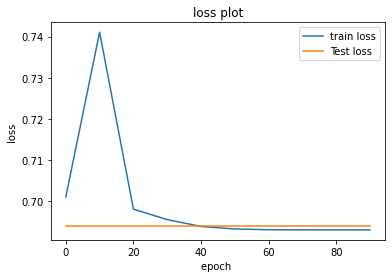

In [130]:
#plot of loss and accuracy


plt.plot(epoch_count,torch.tensor(train_loss_values).detach().numpy(),label="train loss")
plt.plot(epoch_count,torch.tensor(test_loss_values).detach().numpy(),label="Test loss")

plt.title("loss plot")
plt.xlabel("epoch ")
plt.ylabel("loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

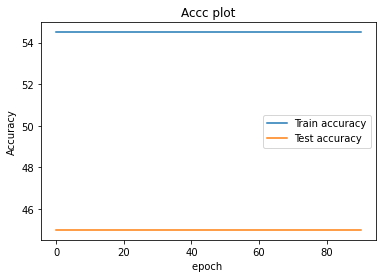

In [131]:
plt.plot(epoch_count,torch.tensor(train_accuracy).detach().numpy(),label="Train accuracy")
plt.plot(epoch_count,torch.tensor(test_accuracy).detach().numpy(),label="Test accuracy")
plt.title("Accc plot")
plt.xlabel("epoch ")
plt.ylabel("Accuracy")
plt.legend()
plt.show

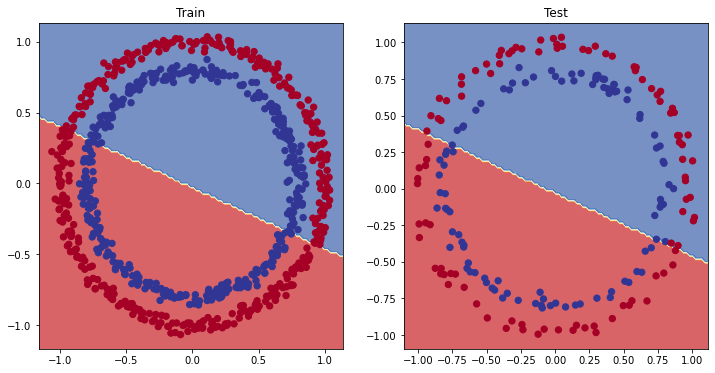

In [134]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

In [135]:
## non-linearity
#recreating non-linear data

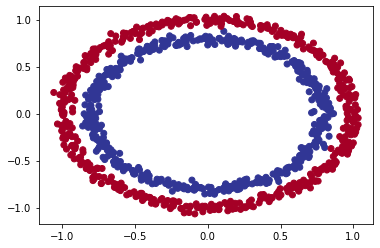

In [138]:
#make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples=1000
X,y=make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [139]:
#convert data to tensor
import torch
from sklearn.model_selection import train_test_split

#turn in tensor.
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [204]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [205]:
y_train.shape,y_test.shape

(torch.Size([800]), torch.Size([200]))

In [273]:
#model with nonlinearity
from torch import nn 

class CircleModel2(nn.Module):
    def __init__(self):
        super(CircleModel2,self).__init__()
        self.layer1= nn.Linear(in_features=2, out_features=128)
        self.layer2= nn.Linear(in_features=128, out_features=32)
        self.layer3= nn.Linear(in_features=32, out_features=1)
        self.relu= nn.LeakyReLU()
    
    def forward(self,x):
        z=self.layer1(x)
        z=self.relu(z)
        z=self.layer2(z)
        z=self.relu(z)
        z=self.layer3(z)
        return z

In [274]:
model_3=CircleModel2().to(device)

In [275]:
model_3

CircleModel2(
  (layer1): Linear(in_features=2, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [276]:
#create a loss function
loss_func=torch.nn.BCEWithLogitsLoss()
#create a optimizer
optimizer=torch.optim.SGD(model_3.parameters(),lr=0.01)

In [279]:
#create a training and optimization loop
torch.manual_seed(42)
epochs=2500
#put data in target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_pred_logits=model_3(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_pred_logits))
    
    accuracy=acc_func(y_train,y_pred)
    
    loss=loss_func(y_pred_logits,y_train)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        y_test_logits= model_3(X_test).squeeze()
        y_test_pred=torch.round(torch.sigmoid(y_test_logits))
        loss_test=loss_func(y_test_logits,y_test)
        accuracy_test=acc_func(y_test,y_test_pred)
        
        if epoch % 50==0:
            print(f"Epoch : {epoch} Train loss : {loss:.5f} Train Acc : {accuracy:.2f} Test loss : {loss_test:.5f} Test Acc : {accuracy_test:.2f} ")

Epoch : 0 Train loss : 0.67732 Train Acc : 78.00 Test loss : 0.68231 Test Acc : 73.00 
Epoch : 50 Train loss : 0.67644 Train Acc : 78.25 Test loss : 0.68165 Test Acc : 74.50 
Epoch : 100 Train loss : 0.67553 Train Acc : 78.62 Test loss : 0.68092 Test Acc : 74.50 
Epoch : 150 Train loss : 0.67458 Train Acc : 79.25 Test loss : 0.68015 Test Acc : 75.50 
Epoch : 200 Train loss : 0.67358 Train Acc : 79.75 Test loss : 0.67934 Test Acc : 76.00 
Epoch : 250 Train loss : 0.67252 Train Acc : 79.88 Test loss : 0.67846 Test Acc : 76.00 
Epoch : 300 Train loss : 0.67131 Train Acc : 80.12 Test loss : 0.67745 Test Acc : 76.00 
Epoch : 350 Train loss : 0.67012 Train Acc : 80.12 Test loss : 0.67650 Test Acc : 76.00 
Epoch : 400 Train loss : 0.66888 Train Acc : 80.38 Test loss : 0.67550 Test Acc : 76.00 
Epoch : 450 Train loss : 0.66759 Train Acc : 80.38 Test loss : 0.67444 Test Acc : 75.50 
Epoch : 500 Train loss : 0.66623 Train Acc : 80.75 Test loss : 0.67333 Test Acc : 74.00 
Epoch : 550 Train loss :

In [280]:
model_3.eval()
with torch.inference_mode():
    y_preds=torch.round(torch.sigmoid(model_3(X_test.to(device)))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

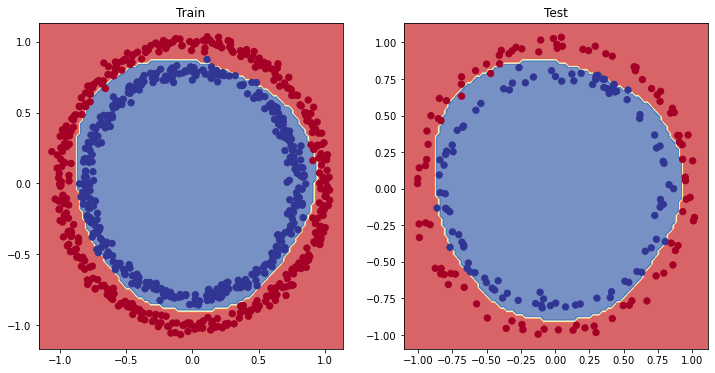

In [281]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [282]:
# replication of non linear unit

In [283]:
#create a tensor
A=torch.arange(-10,10,1, dtype=torch.float32)

In [284]:
A.dtype

torch.float32

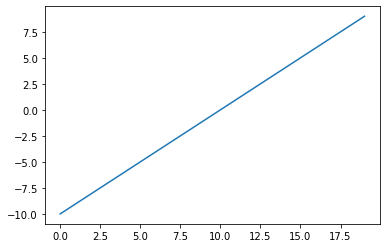

In [285]:
plt.plot(A)

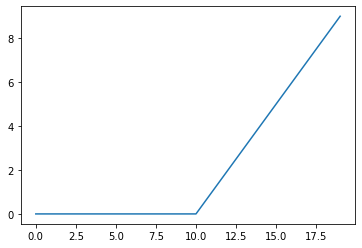

In [287]:
plt.plot(torch.relu(A))

In [292]:
def rel(x: torch.Tensor)-> torch.Tensor:
    return torch.maximum(torch.tensor(0),x)

In [293]:
rel(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

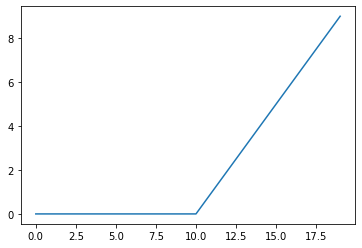

In [295]:
plt.plot(rel(A))

In [296]:
import math

In [297]:
#sigmoid
def sigmoid(x):
    return 1/(1+torch.exp(-x))

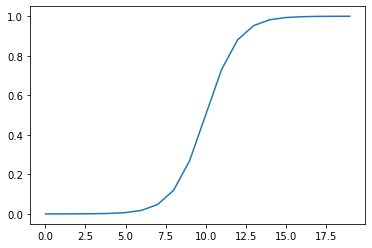

In [298]:
plt.plot(torch.sigmoid(A))

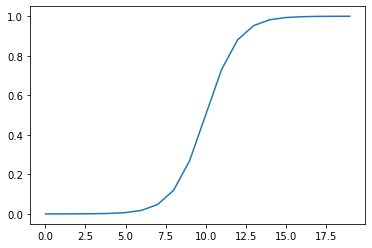

In [299]:
plt.plot(sigmoid(A))